In [1]:
# ML Project Deepan Kumar

# import stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import linear_model, metrics
pd.options.mode.chained_assignment = None  
import warnings
warnings.filterwarnings('ignore') 

# evaluation metric, as specified by competition
def RMSLE(pred, actual):
    return np.sqrt(metrics.mean_squared_log_error(actual, pred))

# general data processing steps
def processDataGeneral(startTraining, endTraining, startTesting, endTesting):

    # get data
    dftrain = pd.read_csv('train1.csv')
    dftest = pd.read_csv('test.csv')

    # used for testing only part of the data set
    dftrain = dftrain.iloc[:] #2070
    dftestX = dftest.iloc[:] #774

    # make a location column which combines country and state to create specific location
    dftrain['Province_State'].fillna("", inplace=True)
    dftrain['Country_Region'].fillna("", inplace=True)
    dftrain['Location'] = dftrain['Province_State'] + " , " + dftrain['Country_Region']
    dftestX['Province_State'].fillna("", inplace=True)
    dftestX['Country_Region'].fillna("", inplace=True)
    dftestX['Location'] = dftestX['Province_State'] + " , " + dftestX['Country_Region']

    # this splits the train and test data by specified dates
    # actual values for cases/fatalities testing are actually in the train.csv file for some reason
    # probably because there was another version of this competition a week after
    # regardless, this is leaked data, that shouldn't be used for testing, so take these out and keep separately
    dftestY = dftrain.query("Date >= " + startTesting).query("Date <= " + (endTesting))

    # last useable date for predictions training is 04-14-2020 according to competition rules
    dftrain = dftrain.query("Date >= " + (startTraining)).query("Date <= " + (endTraining))
    dftestX = dftestX.query("Date >= " + (startTesting)).query("Date <= " + (endTesting))

    # convert date to number of days since first day
    dftrain['Date'] = pd.to_datetime(dftrain['Date']).sub(pd.Timestamp((startTraining))).dt.days
    dftestX['Date'] = pd.to_datetime(dftestX['Date']).sub(pd.Timestamp((startTraining))).dt.days
    dftestY['Date'] = pd.to_datetime(dftestY['Date']).sub(pd.Timestamp((startTraining))).dt.days
    
    return dftrain, dftestX, dftestY



In [158]:
# simple least squares regression on cases or fatalities vs time
# log transforms of these were also trialled but didn't produce good results

def simpleRegression(startTraining, endTraining, startTesting, endTesting):
    
    dftrain, dftestX, dftestY = processDataGeneral(startTraining, endTraining, startTesting, endTesting)

    predictedCases = []
    actualCases = []
    predictedFatalities = []
    actualFatalities = []

    # iterate through all unique locations, fit model, predict and then plot
    for l in dftrain['Location'].unique():
        
        train = dftrain[dftrain['Location'] == l]
        
        # for training, x is date or days, y is confirmed cases
        trainx = np.array(train.loc[:,'Date']).reshape(-1,1)
        trainy = (train.loc[:,'ConfirmedCases'])
        
        # want coefficient to be positive since cumulative cases or fatalities should never decrease
        reg = linear_model.LinearRegression(positive=True).fit(trainx, (trainy))
        # dates to predict on
        testx = (dftestX[dftestX['Location'] == l].loc[:,'Date'])
        # actual values for cases
        testy = dftestY[dftestY['Location'] == l].loc[:,'ConfirmedCases']
        pred = ((reg.predict(np.array(testx).reshape(-1,1))))
        
        # add predictions into array
        predictedCases.extend(pred)
        actualCases.extend(testy)
        
        # essentially the same thing, but for fatalities instead of cases now
        trainFatal = dftrain[dftrain['Location'] == l]
        # x is date, y is fatalities
        trainxFatal = np.array(trainFatal.loc[:,'Date']).reshape(-1,1)
        trainyFatal = (trainFatal.loc[:,'Fatalities'])
        regFatal = linear_model.LinearRegression(positive=True).fit(trainxFatal, (trainyFatal))
        testxFatal = (dftestX[dftestX['Location'] == l].loc[:,'Date'])
        testyFatal = dftestY[dftestY['Location'] == l].loc[:,'Fatalities']
        predFatal = (regFatal.predict(np.array(testxFatal).reshape(-1,1)))

        # add predictions into array
        predictedFatalities.extend(predFatal)
        actualFatalities.extend(testyFatal)

        # plot predicted vs actual, uncomment this to produce plots
    #     plt.figure()
    #     # plot predicted forecast
    #     plt.plot(testx,pred)
    #     # plot actual cases
    #     plt.plot(testx,testy)
    #     # plot cases beforehand
    #     #plt.plot(trainxFatal,np.expm1(trainyFatal))
    #     plt.plot(trainx,(trainy))
    #     plt.title(l)
    #     plt.xlabel('Date/Days')
    #     plt.ylabel('Cases/Fatalities')
    #     plt.show()

    return predictedCases,actualCases,predictedFatalities,actualFatalities

# call function, using dates specified in competition
predictedCases,actualCases,predictedFatalities,actualFatalities = simpleRegression("'2020-03-14'","'2020-04-14'","'2020-04-15'", "'2020-05-14'")

# find the error
caseEval = RMSLE(predictedCases,actualCases)
fatalEval = RMSLE(predictedFatalities,actualFatalities)
avgEval = (caseEval+fatalEval)/2

print(caseEval,fatalEval,avgEval)


0.6529243381366514 0.6284371619471605 0.6406807500419059


        T-1      T-2      T-3      T-4      T-5      T-6     T-7     weeklyavg
0    6853.0   6753.0   6644.0   6527.0   6429.0   6362.0  6269.0   6548.142857
1    6932.0   6853.0   6753.0   6644.0   6527.0   6429.0  6362.0   6642.857143
2    7044.0   6932.0   6853.0   6753.0   6644.0   6527.0  6429.0   6740.285714
3    7168.0   7044.0   6932.0   6853.0   6753.0   6644.0  6527.0   6845.857143
4    7303.0   7168.0   7044.0   6932.0   6853.0   6753.0  6644.0   6956.714286
5    7462.0   7303.0   7168.0   7044.0   6932.0   6853.0  6753.0   7073.571429
6    7603.0   7462.0   7303.0   7168.0   7044.0   6932.0  6853.0   7195.000000
7    7754.0   7603.0   7462.0   7303.0   7168.0   7044.0  6932.0   7323.714286
8    7929.0   7754.0   7603.0   7462.0   7303.0   7168.0  7044.0   7466.142857
9    8105.0   7929.0   7754.0   7603.0   7462.0   7303.0  7168.0   7617.714286
10   8342.0   8105.0   7929.0   7754.0   7603.0   7462.0  7303.0   7785.428571
11   8514.0   8342.0   8105.0   7929.0   7754.0   76

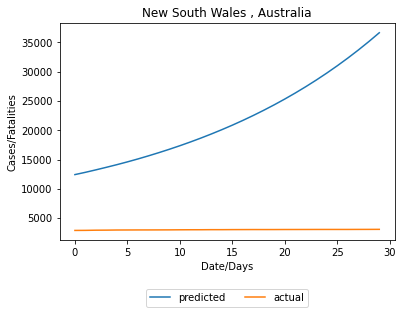

[[12424.39164674]
 [12813.91961042]
 [13235.07189943]
 [13671.41687585]
 [14121.63015548]
 [14596.45291501]
 [15096.36259138]
 [15623.42701275]
 [16175.51125527]
 [16752.38499309]
 [17358.18115987]
 [17994.61016789]
 [18662.92890905]
 [19363.98530693]
 [20098.91303162]
 [20870.12346116]
 [21679.63213633]
 [22529.1608838 ]
 [23420.49764152]
 [24355.58104371]
 [25336.74619726]
 [26366.3608906 ]
 [27446.75346114]
 [28580.36951025]
 [29769.80514963]
 [31017.85483702]
 [32327.44016916]
 [33701.57655824]
 [35143.42635607]
 [36656.32106069]]
0.7076927228276874


In [20]:
# autoregressive model for cases using past cases as features, with ridge/lasso penalisation
# note: this function takes a while to run (couple minutes usually)

def casesLagPredictor(startTraining, endTraining, startTesting, endTesting, a, lasso):
    dftrain, dftestX, dftestY = processDataGeneral(startTraining, endTraining, startTesting, endTesting)

    predictedCases = []
    actualCases = []

    #iterate through all unique locations, fit model, predict and then plot
    for l in dftrain['Location'].unique():

        # create lag features with the past daily cumulative cases over the past week, as well as the mean of these
        train = dftrain[dftrain['Location'] == l]
        dfshifted = train
        dfshifted = dfshifted.drop(columns=['Id', "Province_State", "Country_Region","Date","Location","Fatalities" ])
        dfshifted = pd.concat([dfshifted,dfshifted.shift(1),dfshifted.shift(2),dfshifted.shift(3),dfshifted.shift(4),dfshifted.shift(5),dfshifted.shift(6),dfshifted.shift(7)], axis=1)
        colNames = []
        for j in range(1, 8):
            dfshifted.columns.values[j] = "T-" + str(j)
            colNames.append(dfshifted.columns.values[j])
        dfshifted["weeklyavg"] = dfshifted[['T-1','T-2','T-3','T-4','T-5','T-6','T-7']].mean(axis=1)
        dfshifted = dfshifted.drop(columns=['ConfirmedCases'])
        train = pd.concat([train, dfshifted], axis=1)
        train = train.dropna()

        # x is previous cases over the week and average, y is num of confirmed cases
        trainx = train.iloc[:,7:15]
        trainx = trainx.reset_index(drop=True)
        trainy = np.array(train['ConfirmedCases'])

        # fit model, depending on parameters passed in
        if (lasso == True):
            reg = linear_model.Lasso(alpha=a, positive=True).fit(trainx, trainy)
        else:
            reg = linear_model.Ridge(alpha=a).fit(trainx, trainy)
        #print(reg.coef_)

        # all the dates left to predict on
        testx = dftestX[dftestX['Location'] == l]
        # add in lag features columns for the test data
        testx = testx.reindex(columns=[*testx.columns.tolist(), *colNames], fill_value=0)
        # input for first row of test data is last row of training data shifted 1 day,
        # with the last confirmed case as T-1 instead
        testx.iloc[0,6:12] = np.array(trainx.iloc[-1, 0:6])
        # add on last confirmed case from training data as T-1 for test data
        testx.iloc[0,5] = trainy[-1] 
        # calculate average of lag features
        testx["weeklyavg"] = testx[['T-1','T-2','T-3','T-4','T-5','T-6','T-7']].mean(axis=1)
        testx = testx.reset_index(drop=True)

        # actual cases for those dates
        testy = dftestY[dftestY['Location'] == l].loc[:,'ConfirmedCases']
        testy = testy.reset_index(drop=True)
        predictedCountry = []
        actualCountry = []
        previousPred = trainy[-1]
        if (l=="New South Wales , Australia"):
            print(trainx)
            print(testx)
        
        # for each day in the test data, predict just the value for the next day based on lag features input,
        # and then add this preidction as a lag feature (input) for the next day
        for i in range(0, len(testx)):
            
            # predict just the next day's cases
            pred = reg.predict(np.array(testx.iloc[i,5:13]).reshape(1, -1))
            predExp = pred 

            # ensures that the new prediciton is always greater than or equal to previous prediction
            # this is because cumulative cases should never decrease
            if previousPred > predExp:
                predExp = previousPred
                
            # makes prediction average of new preidction and previous, to stop major daily fluctuations
            #predExp = 0.5*predExp + 0.5*previousPred
            previousPred = predExp

            predictedCases.append(np.ndarray.item(np.array(predExp)))
            actualCases.append(testy[i])
            predictedCountry.append(np.ndarray.item(np.array(predExp)))
            actualCountry.append(testy[i])
            
            # add predicted value as lag feature for next day as T-1, then shift rest of lag features 1 day
            if (i < (len(testx)-1)): 
                testx.iloc[i+1,6:12] = np.array(testx.iloc[i,5:11])
                testx.iloc[i+1,5] = predExp
                testx["weeklyavg"] = testx[['T-1','T-2','T-3','T-4','T-5','T-6','T-7']].mean(axis=1)

        # plot predicted vs actual for each country, uncomment to plot
        if (l=="New South Wales , Australia"):
            print(testx)
            plt.figure()
            # plot predicted forecast
            plt.plot(predictedCountry, label='predicted')
            # plot actual cases
            plt.plot(actualCountry, label='actual')
            plt.title(l)
            plt.xlabel('Date/Days')
            plt.ylabel('Cases/Fatalities')
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
            plt.show()
            print(np.array(predictedCountry).reshape(-1,1))
    
    
    return predictedCases, actualCases


# run function with ideal hyperparameters on competition dates
predictedCases, actualCases = casesLagPredictor("'2020-03-15'","'2020-04-14'","'2020-04-15'", "'2020-05-14'",1000 ,False)
# evaluate error
caseEval = RMSLE(predictedCases,actualCases)
print(caseEval)



In [160]:
# autoregressive model for fatalities using past cases as features, with ridge/lasso penalisation
# note: this function takes a while to run (couple minutes usually)

def fatalLagPredictorNew(startTraining, endTraining, startTesting, endTesting, a, lasso):
    
    # first get case predictions using caseLag Model, as this will be needed as input for
    # the lag features for the test data
    # this only includes cases in the test data
    predictedCases, actualCases = casesLagPredictor(startTraining,endTraining,startTesting,endTesting,1.3,True)
    
    # use cases from training cases (for training input) and predicted cases (for test input)
    # to produce lag features, dont include fatalities as a lag feature, just keep as a response
    dftrain, dftestX, dftestY = processDataGeneral(startTraining, endTraining, startTesting, endTesting)

    predictedFatal = []
    actualFatal = []
    
    # to keep track of what day from predictedCases we are up to using
    caseCounter = 0
    
    #iterate through all unique locations, fit model, predict and then plot
    for l in dftrain['Location'].unique():

        # create lag features with just cases
        train = dftrain[dftrain['Location'] == l]
        dfshifted = train
        dfshifted = dfshifted.drop(columns=['Id', "Province_State", "Country_Region","Date","Location","Fatalities" ])
        dfshifted = pd.concat([dfshifted,dfshifted.shift(1),dfshifted.shift(2),dfshifted.shift(3),dfshifted.shift(4),dfshifted.shift(5),dfshifted.shift(6),dfshifted.shift(7)], axis=1)
        colNames = []
        for j in range(1, 8):
            dfshifted.columns.values[j] = "T-" + str(j)
            colNames.append(dfshifted.columns.values[j])
        dfshifted["weeklyavg"] = dfshifted[['T-1','T-2','T-3','T-4','T-5','T-6','T-7']].mean(axis=1)
        dfshifted = dfshifted.drop(columns=['ConfirmedCases'])
        train = pd.concat([train, dfshifted], axis=1)
        train = train.dropna()

        # x is previous cases over the week and average, y is num of fatalities
        trainx = train.iloc[:,7:15]
        trainx = trainx.reset_index(drop=True)
        trainy = np.array(train.loc[:,'Fatalities'])

        # fit model
        if (lasso == True):
            reg = linear_model.Lasso(alpha=a, positive=True).fit(trainx, trainy)
        else:
            reg = linear_model.Ridge(alpha=a).fit(trainx, trainy)
        #print(reg.coef_)

        # all the dates left to predict on
        testx = dftestX[dftestX['Location'] == l]
        # add in lag features columns
        testx = testx.reindex(columns=[*testx.columns.tolist(), *colNames], fill_value=0)
        # input for first row of test data is last row of training data, with the predicted case as T-1
        # need to get this prediction from predictions from cases autoregressive model
        testx.iloc[0,6:12] = trainx.iloc[-1, 1:7] 
        testx.iloc[0,5] = predictedCases[caseCounter] 
        caseCounter = caseCounter + 1
        testx["weeklyavg"] = testx[['T-1','T-2','T-3','T-4','T-5','T-6','T-7']].mean(axis=1)
        testx = testx.reset_index(drop=True)

        # actual fatalities for those dates
        testy = dftestY[dftestY['Location'] == l].loc[:,'Fatalities']
        testy = testy.reset_index(drop=True)
        
        predictedCountry = []
        actualCountry = []
        previousPred = trainy[-1]

        # for each day in the test data, predict just the value for the next day based on lag features input,
        # use the output of cases predictions as input for lag features for fatality predictions
        for i in range(0, len(testx)):
            
            # predict just the next days fatalities
            pred = reg.predict(np.array(testx.iloc[i,5:13]).reshape(1, -1))
            predExp = pred 

            # ensures that the new prediciton is always greater than or equal to previous prediction
            # this is because cumulative fatalities should never decrease
            if previousPred > predExp:
                predExp = previousPred
            # makes prediction average of new preidction and previous, to stop major daily fluctuations
            predExp = 0.5*predExp + 0.5*previousPred
            previousPred = predExp

            predictedFatal.append(np.ndarray.item(np.array(predExp)))
            actualFatal.append(testy[i])
            predictedCountry.append(np.ndarray.item(np.array(predExp)))
            actualCountry.append(testy[i])

            # set T-1 of next row in test data tp be predicted cases from the cases autoregr model
            # shift lag cases across 1 day
            if (i < (len(testx)-1)): 
                testx.iloc[i+1,6:12] = np.array(testx.iloc[i,5:11])
                testx.iloc[i+1,5] = predictedCases[caseCounter]
                caseCounter = caseCounter + 1
                testx["weeklyavg"] = testx[['T-1','T-2','T-3','T-4','T-5','T-6','T-7']].mean(axis=1)
           

        # plot predicted vs actual for each country, uncomment to plot
#         plt.figure()
#         # plot predicted forecast
#         plt.plot(predictedCountry)
#         # plot actual cases
#         plt.plot(actualCountry)
#         plt.title(l)
#         plt.xlabel('Date/Days')
#         plt.ylabel('Cases/Fatalities')
#         plt.show()
    
    
    return predictedFatal, actualFatal


# case counter should be equal to length of predictedCases by the end

# call function with ideal hyperparams and dates according to competition
predictedFatal, actualFatal = fatalLagPredictorNew("'2020-03-14'","'2020-04-14'","'2020-04-15'", "'2020-05-14'",1800 ,False)
#evaluate 
fatalEval = RMSLE((predictedFatal), actualFatal)
print(fatalEval)


0.5050903743982299


0.01 0.20255
0.1 0.19925
0.5 0.19761
1 0.19646
5 0.19968
10 0.20103
50 0.20641
100 0.20923
200 0.214
500 0.22061
1000 0.22753
2000 0.23257
5000 0.23823
10000 0.24332
3
0.1964606304089187


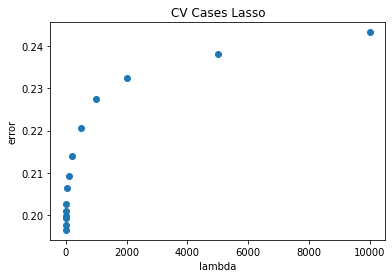

0.01 0.45126
0.1 0.31723
0.5 0.25612
1 0.24414
5 0.231
10 0.22569
50 0.21451
100 0.2124
200 0.21056
500 0.20793
1000 0.20681
2000 0.20703
5000 0.20943
10000 0.21282
10
0.20681023014184585


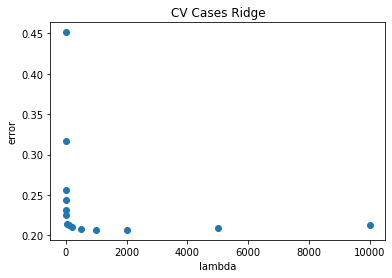

0.01 0.23629
0.1 0.23484
0.5 0.23451
1 0.235
5 0.23539
10 0.23735
50 0.24528
100 0.25111
200 0.25733
500 0.26543
1000 0.27241
2000 0.27803
5000 0.28535
10000 0.28966
2
0.2345099321823092


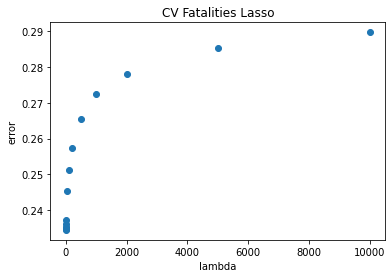

0.01 0.28618
0.1 0.27333
0.5 0.26013
1 0.25399
5 0.24334
10 0.24078
50 0.2366
100 0.23523
200 0.23418
500 0.23343
1000 0.23306
2000 0.23292
5000 0.23342
10000 0.23396
11
0.23291569880606425


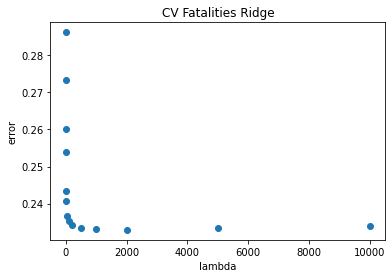

0.5 0.19761
0.6 0.19733
0.7 0.19699
0.7999999999999999 0.19687
0.8999999999999999 0.19665
0.9999999999999999 0.19646
1.0999999999999999 0.19627
1.1999999999999997 0.19607
1.2999999999999998 0.19598
1.4 0.19613
1.4999999999999998 0.19669
1.5999999999999996 0.19694
1.6999999999999997 0.19698
1.7999999999999998 0.19703
1.8999999999999997 0.19707
1.9999999999999996 0.19711
2.0999999999999996 0.19715
2.1999999999999997 0.1972
2.3 0.19725
2.3999999999999995 0.1973
2.4999999999999996 0.19734
2.5999999999999996 0.19739
2.6999999999999993 0.19744
2.7999999999999994 0.1975
2.8999999999999995 0.19756
2.9999999999999996 0.19763
3.0999999999999996 0.19771
3.1999999999999993 0.19779
3.2999999999999994 0.19788
3.3999999999999995 0.19797
3.499999999999999 0.19807
3.599999999999999 0.19818
3.6999999999999993 0.1983
3.7999999999999994 0.19844
3.8999999999999995 0.19859
3.999999999999999 0.19876
4.1 0.19894
4.199999999999999 0.19913
4.299999999999999 0.19925
4.399999999999999 0.19936
4.499999999999999 0.

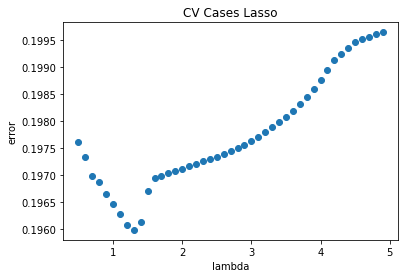

5.0 0.19968
5.1 0.19971
5.199999999999999 0.19974
5.299999999999999 0.19977
5.399999999999999 0.19981
5.499999999999998 0.19984
5.599999999999998 0.19988
5.6999999999999975 0.19991
5.799999999999997 0.19995
5.899999999999997 0.19999
5.9999999999999964 0.20002
6.099999999999996 0.20006
6.199999999999996 0.20009
6.299999999999995 0.20013
6.399999999999995 0.20015
6.499999999999995 0.20017
6.599999999999994 0.20019
6.699999999999994 0.20022
6.799999999999994 0.20024
6.899999999999993 0.20026
6.999999999999993 0.20028
7.0999999999999925 0.20031
7.199999999999992 0.20033
7.299999999999992 0.20035
7.3999999999999915 0.20037
7.499999999999991 0.2004
7.599999999999991 0.20042
7.69999999999999 0.20044
7.79999999999999 0.20047
7.89999999999999 0.20049
7.999999999999989 0.20051
8.099999999999989 0.20054
8.199999999999989 0.20057
8.299999999999988 0.20059
8.399999999999988 0.20062
8.499999999999988 0.20064
8.599999999999987 0.20067
8.699999999999987 0.20069
8.799999999999986 0.20072
8.899999999999

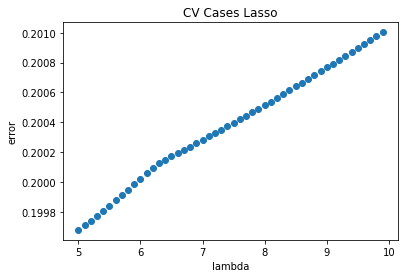

500 0.20793
600 0.20754
700 0.20727
800 0.20709
900 0.20692
1000 0.20681
1100 0.20673
1200 0.2067
1300 0.20669
1400 0.2067
1500 0.20672
1600 0.20676
1700 0.20682
1800 0.20688
1900 0.20695
2000 0.20703
2100 0.20711
2200 0.20721
2300 0.2073
2400 0.20739
2500 0.20747
2600 0.20755
2700 0.20764
2800 0.20773
2900 0.20782
3000 0.2079
3100 0.20798
3200 0.20807
3300 0.20815
3400 0.20822
3500 0.2083
3600 0.20837
3700 0.20844
3800 0.20851
3900 0.20858
4000 0.20865
4100 0.20873
4200 0.2088
4300 0.20888
4400 0.20896
4500 0.20904
4600 0.20912
4700 0.20919
4800 0.20927
4900 0.20935
8
0.20669030257622997


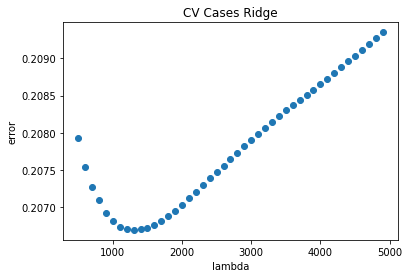

0.5 0.23451
0.6 0.23461
0.7 0.23471
0.7999999999999999 0.2348
0.8999999999999999 0.2349
0.9999999999999999 0.235
1.0999999999999999 0.23502
1.1999999999999997 0.23499
1.2999999999999998 0.23496
1.4 0.23496
1.4999999999999998 0.23496
1.5999999999999996 0.23492
1.6999999999999997 0.23488
1.7999999999999998 0.23485
1.8999999999999997 0.23482
1.9999999999999996 0.23477
2.0999999999999996 0.23472
2.1999999999999997 0.2347
2.3 0.23469
2.3999999999999995 0.23468
2.4999999999999996 0.23467
2.5999999999999996 0.23466
2.6999999999999993 0.23466
2.7999999999999994 0.23466
2.8999999999999995 0.23466
2.9999999999999996 0.23466
3.0999999999999996 0.23467
3.1999999999999993 0.23468
3.2999999999999994 0.23469
3.3999999999999995 0.23471
3.499999999999999 0.23474
3.599999999999999 0.23477
3.6999999999999993 0.23481
3.7999999999999994 0.23486
3.8999999999999995 0.23492
3.999999999999999 0.23498
4.1 0.23504
4.199999999999999 0.23508
4.299999999999999 0.23511
4.399999999999999 0.23514
4.499999999999999 0.2

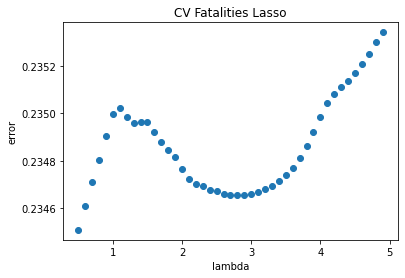

5.0 0.23539
5.1 0.23544
5.199999999999999 0.23549
5.299999999999999 0.23557
5.399999999999999 0.23564
5.499999999999998 0.2357
5.599999999999998 0.23576
5.6999999999999975 0.23581
5.799999999999997 0.23586
5.899999999999997 0.2359
5.9999999999999964 0.23595
6.099999999999996 0.23598
6.199999999999996 0.23602
6.299999999999995 0.23606
6.399999999999995 0.23611
6.499999999999995 0.23615
6.599999999999994 0.2362
6.699999999999994 0.23624
6.799999999999994 0.23629
6.899999999999993 0.23634
6.999999999999993 0.23638
7.0999999999999925 0.23643
7.199999999999992 0.23648
7.299999999999992 0.23652
7.3999999999999915 0.23656
7.499999999999991 0.23661
7.599999999999991 0.23665
7.69999999999999 0.23669
7.79999999999999 0.23673
7.89999999999999 0.23677
7.999999999999989 0.2368
8.099999999999989 0.23684
8.199999999999989 0.23687
8.299999999999988 0.2369
8.399999999999988 0.23694
8.499999999999988 0.23696
8.599999999999987 0.23699
8.699999999999987 0.23702
8.799999999999986 0.23706
8.899999999999986 

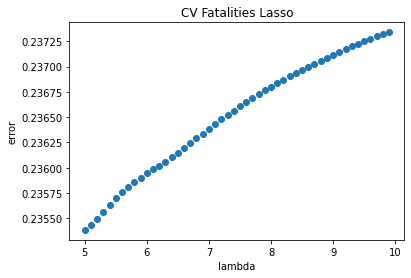

500 0.23343
600 0.23331
700 0.23323
800 0.23316
900 0.2331
1000 0.23306
1100 0.23302
1200 0.23298
1300 0.23295
1400 0.23292
1500 0.23292
1600 0.23291
1700 0.2329
1800 0.2329
1900 0.23291
2000 0.23292
2100 0.23293
2200 0.23294
2300 0.23296
2400 0.23298
2500 0.233
2600 0.23303
2700 0.23305
2800 0.23308
2900 0.2331
3000 0.23313
3100 0.23315
3200 0.23317
3300 0.2332
3400 0.23322
3500 0.23324
3600 0.23326
3700 0.23327
3800 0.23329
3900 0.2333
4000 0.23331
4100 0.23332
4200 0.23334
4300 0.23335
4400 0.23336
4500 0.23337
4600 0.23338
4700 0.2334
4800 0.23341
4900 0.23342
12
0.23290192876612484


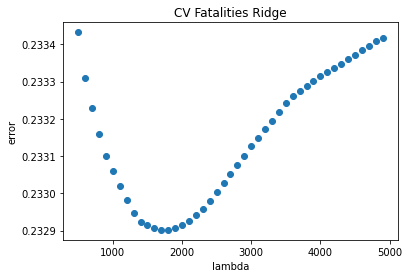

In [125]:
# cross validation

# construct 3 date period folds to train and test on
# folds had to be chosen such that the training data was before the test data in terms of date,
# as this is a forecasting model, hence the folds were constructed manually

# train: 2020-03-14 to 2020-03-28
# test: 2020-03-29 to 2020-04-02

# train: 2020-03-19 to 2020-04-02
# test: 2020-04-03 to 2020-04-08

# train: 2020-03-24 to 2020-04-08
# test: 2020-04-09 to 2020-04-14

# lets you choose what lambdas to test, whether to use ridge or lasso and which predictor is being validated
def crossValidate(lambdas, lassoPenalty, casePredictor, title):
    trainSplit = [["'2020-03-14'","'2020-03-28'"],["'2020-03-19'","'2020-04-02'"],["'2020-03-24'","'2020-04-08'"]]
    testSplit = [["'2020-03-29'","'2020-04-02'"],["'2020-04-03'","'2020-04-08'"],["'2020-04-09'","'2020-04-14'"]]
    
    lambdasErrors = []
    
    for i in range(0, len(lambdas)):
        totalError = 0.0
        # find error for each fold
        for j in range(0, len(trainSplit)):
            if (casePredictor):
                pred,act = casesLagPredictor(trainSplit[j][0],trainSplit[j][1],testSplit[j][0],testSplit[j][1],lambdas[i],lassoPenalty)
            else:
                pred,act = fatalLagPredictorNew(trainSplit[j][0],trainSplit[j][1],testSplit[j][0],testSplit[j][1],lambdas[i],lassoPenalty)   
            totalError = totalError + RMSLE(pred, act)

        # take average error over each split
        lambdasErrors.append(totalError/len(trainSplit))
    
    # find best lambda
    minIndex = -1
    minError = 10
    for i in range(0, len(lambdas)):
        print(lambdas[i], round(lambdasErrors[i],5))
        if (lambdasErrors[i] < minError):
            minIndex = i
            minError = lambdasErrors[i]
        
    # create a plot

    print(minIndex)
    print(minError)
    plt.scatter(lambdas,lambdasErrors)
    plt.title(title)
    plt.xlabel('lambda')
    plt.ylabel('error')
    plt.show()
    

lambdaTest = [1]
lambdasInitial = [0.01, 0.1, 0.5, 1, 5, 10, 50, 100, 200, 500, 1000, 2000,5000,10000]
lambdasFine = np.arange(0.5, 5.0, 0.1)
lambdasFine2 = np.arange(5.0, 10.0, 0.1)
lambdasFine3 = np.arange(500, 5000, 100)

# initial coarse CV to get ballpark and best penalisation term
crossValidate(lambdasInitial, True, True, "CV Cases Lasso")
crossValidate(lambdasInitial, False, True, "CV Cases Ridge")
crossValidate(lambdasInitial, True, False, "CV Fatalities Lasso")
crossValidate(lambdasInitial, False, False, "CV Fatalities Ridge")

# detailed, fine CV
crossValidate(lambdasFine, True, True, "CV Cases Lasso")
crossValidate(lambdasFine2, True, True, "CV Cases Lasso")
crossValidate(lambdasFine3, False, True, "CV Cases Ridge")
crossValidate(lambdasFine, True, False, "CV Fatalities Lasso")
crossValidate(lambdasFine2, True, False, "CV Fatalities Lasso")
crossValidate(lambdasFine3, False, False, "CV Fatalities Ridge")


# note: running this will take a couple hours probably, cached results should be visible in jupyter notebook below hopefully:




In [161]:
# final selection of model
# train on first 3 weeks, test on last week for each model
# then with best model, train on all training data, then validate wiht actual test data

predC,actualC,predictedF,actualF = simpleRegression("'2020-03-14'","'2020-04-07'","'2020-04-08'", "'2020-04-14'")
caseEval = RMSLE(predC,actualC)
fatalEval = RMSLE(predictedF,actualF)
avgEval = (caseEval+fatalEval)/2
print(caseEval,fatalEval,avgEval)

# use ideal hyperparms found from CV
predC,actualC = casesLagPredictor("'2020-03-14'","'2020-04-07'","'2020-04-08'", "'2020-04-14'", 1.3, True)
predictedF,actualF = fatalLagPredictorNew("'2020-03-14'","'2020-04-07'","'2020-04-08'", "'2020-04-14'", 1800, False)
caseEval = RMSLE(predC,actualC)
fatalEval = RMSLE(predictedF,actualF)
avgEval = (caseEval+fatalEval)/2
print(caseEval,fatalEval,avgEval)


# final validation, n competition dataset
predC,actualC = casesLagPredictor("'2020-03-14'","'2020-04-14'","'2020-04-15'", "'2020-05-14'", 1.3, True)
predictedF,actualF = fatalLagPredictorNew("'2020-03-14'","'2020-04-14'","'2020-04-15'", "'2020-05-14'", 1800, False)
caseEval = RMSLE(predC,actualC)
fatalEval = RMSLE(predictedF,actualF)
avgEval = (caseEval+fatalEval)/2
print(caseEval,fatalEval,avgEval)


0.34874743496701216 0.43483946161819803 0.3917934482926051
0.20802362964627175 0.2386652466919066 0.22334443816908917
0.537607206717114 0.5050903743982299 0.5213487905576719
